# Lab3 Implementation of simple RNN and LSTM 

This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech
Shall you have any problem, send me [email](hsiu-wen.chang_joly@mines-paristech.fr)

## Goal

1. many-to-one by RNN: given several words, predict the next word
2. many-to-one by LSTM: given several letters, predict the final letter
3. Adanced exercise: image captioning

### 1. Many-to-one by RNN (word level): Predict what is the next word

Our task today is to predict the next word by given several words before. For example, we expect to have answer to be 'cat' when user key in 'I like'.

In [2]:
# Configuration
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

dtype = torch.float32

#### 1.1 Data preparation

Here are three sentences and each of them has three words. We are going to use it as training sample. The design is to feed first two words and let the machine find the final word. However, the computer can't do mathematic operations on characters. Therefore, the first step is to encode the input to digital numbers. 

In [3]:
# Create the input data, you are welcome to add the words you like
sentences = [ "i like cat", "i love coffee", "i hate milk"]

# Define all the possible words
word_list = " ".join(sentences).split()

word_list = list(set(word_list))

# dictionary that chanage the given word to number. {love: 0, hate:1,...}
word_dict = {w: i for i, w in enumerate(word_list)}

# dictionary that chanage the number to word. {0: love, 1: hate,...}
number_dict = {i: w for i, w in enumerate(word_list)}

# number of class(=number of vocab)
n_class = len(word_dict)

print(word_dict)

{'hate': 0, 'milk': 1, 'cat': 2, 'love': 3, 'coffee': 4, 'like': 5, 'i': 6}


#### 1.2 Data preprocessing

Define batch function to let machine know how he should use it during training.
Here we give all the data we have for simplication. But in real case, you should not do it.


In [5]:
# Function to encode the sentence into a vector 
def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(np.eye(n_class)[target])

    return input_batch, target_batch

In [ ]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_batch, target_batch = make_batch(sentences)
# move input and output to the device
input_batch = torch.tensor(input_batch, device=device, dtype=dtype)
target_batch = torch.tensor(target_batch, device=device, dtype=dtype)

print('Dimension of input_patch:', input_batch.shape) #[batch, N_step, n_class]
print(input_batch)
print(target_batch)

Using device: cuda:0


/tmp/ipykernel_79425/1780498250.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  input_batch = torch.tensor(input_batch, device=device, dtype=dtype)


Dimension of input_patch: torch.Size([3, 2, 7])
tensor([[[0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')
tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')


#### 1.3 Network

Torch.nn provide a function call nn.RNN which is a multi-layer Elman RNN with $tanh$ or $ReLU$ (controlled by nonlinearity parameter) to an input sequence.

The equation to compute the hidden state is $$h_t=tanh(W_{ih}x_t+b_{ih}+w_{hh}h_{t-1}+b_{hh}) $$

Further information about how you can use it, check this [link](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

In [7]:
class TextRNN(nn.Module):
    def __init__(self,n_class=7, n_hidden=5):
        super(TextRNN, self).__init__()

        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))

    def forward(self, hidden, X):
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        outputs, hidden = self.rnn(X, hidden)
        # outputs : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        outputs = outputs[-1] # [batch_size, num_directions(=1) * n_hidden]
        model = torch.mm(outputs, self.W) + self.b # model : [batch_size, n_class]
        return model


In [8]:
# Paramters for the network
batch_size = len(sentences)
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell


In [9]:
# Intialize the model and move it to the device
model = TextRNN(n_class, n_hidden).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Lets see how this model looks like

In [10]:
print(model)

TextRNN(
  (rnn): RNN(7, 5)
)


#### 1.4 Training

In [11]:
# Training
for epoch in range(5000):
    # Reset the gradient buffer 
    optimizer.zero_grad() 

    # hidden : [num_layers * num_directions, batch, hidden_size]
    hidden = torch.zeros(1, batch_size, n_hidden,dtype=dtype, device=device)
    # input_batch : [batch_size, n_step, n_class]
    output = model(hidden, input_batch)
 
    # output : [batch_size, n_class], target_batch : [batch_size, n_class)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 0.067757
Epoch: 2000 cost = 0.012957
Epoch: 3000 cost = 0.004960
Epoch: 4000 cost = 0.002374
Epoch: 5000 cost = 0.001256


#### 1.5 Test the model

In [12]:
# Predict
# Initial hidden state 0
hidden = torch.zeros(1, batch_size, n_hidden, device=device, dtype=dtype)

print('Raw output of this model:\n',model(hidden, input_batch))

predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])#

Raw output of this model:
 tensor([[-2.6051, -1.2329,  7.1195, -1.5664, -0.3203, -1.2171, -1.3364],
        [-1.6788,  0.7000,  0.5579, -3.2250,  8.3175, -0.9592, -1.2771],
        [-0.5906,  8.9017,  0.8643, -0.2319,  1.1061,  0.3046, -1.6670]],
       device='cuda:0', grad_fn=<AddBackward0>)
[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['cat', 'coffee', 'milk']


### Task 1: create the sevearl french words and the corresponding english words by yourself. Train a RNN model that can translate the french word into english word. 

### 2. Many-to-one LSTM (character level): Predict what is the next letter

In this task, we will give our network to predict the final letter for us uisng LSTM. For example, if we key in 'lov' then the machine should give us 'e'

Read this [document](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for the usage of nn.lstm function 

#### 2.1 Data preparation and preprocessing

In [13]:
# we need define all the possible letters
char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']

#word dictionary that can use to get the corresponding encoded number
word_dict = {n: i for i, n in enumerate(char_arr)}

# number dictionary that can be used to get the corresponding letter
number_dict = {i: w for i, w in enumerate(char_arr)}

n_class = len(word_dict) # number of class(=number of vocab)

seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']

In [20]:
def make_batch(seq_data):
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [word_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = word_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(np.eye(n_class)[target])

    return torch.tensor(input_batch, device=device, dtype=dtype), torch.tensor(target_batch, device=device, dtype=dtype)

#### 2.2 Model

In [23]:
# TextLSTM Parameters
n_step = 3
n_hidden = 128

class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, device=device)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))

    def forward(self, X):
        input = X.transpose(0, 1)  # X : [n_step, batch_size, n_class]

        hidden_state = torch.zeros(1, len(X), n_hidden, dtype=dtype, device=device)   # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden, dtype=dtype, device=device)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state)) #outputs, h_n, c_n
        outputs = outputs[-1]  # [batch_size, n_hidden]
        model = torch.mm(outputs, self.W) + self.b  # model : [batch_size, n_class]
        return model

#### 2.3 Training

In [24]:
input_batch, target_batch = make_batch(seq_data)

model = TextLSTM().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

output = model(input_batch)

# Training
for epoch in range(1000):
    optimizer.zero_grad()

    output = model(input_batch)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

Epoch: 0100 cost = 0.012384
Epoch: 0200 cost = 0.002684
Epoch: 0300 cost = 0.001210
Epoch: 0400 cost = 0.000692
Epoch: 0500 cost = 0.000449
Epoch: 0600 cost = 0.000315
Epoch: 0700 cost = 0.000233
Epoch: 0800 cost = 0.000180
Epoch: 0900 cost = 0.000142
Epoch: 1000 cost = 0.000116


#### 2.4 Testing the model

In [25]:
inputs = [sen[:3] for sen in seq_data]

predict = model(input_batch).data.max(1, keepdim=True)[1]
print(inputs, '->', [number_dict[n.item()] for n in predict.squeeze()])

['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


### Task 2: 

1. Use whatever way you like, add more than 20 vocabulary and reuse the code to do the same task
1. modify the model to make it predict one word each time


## Conclusion

You should think about the problem when we have much bigger vocabulary that using dict to enumerate the words will make it very inefficient.
"Embedding" and "Tokenizer" are the two soltuions available in [PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html). 


In [26]:
# an Embedding module containing 10 tensors of size 3: it is a simple lookup table that stores embeddings of a fixed dictionary and size.
embedding = nn.Embedding(10, 3)

# a batch of 2 samples of 4 indices each
input = torch.tensor([[1, 2, 4, 5], [4, 3, 2, 9]])
print(input.shape)
print(input)
output = embedding(input)
print(output.shape)  # output : [2, 4, 3] -> [batch_size, n_step, embedding_size]
print(output)

torch.Size([2, 4])
tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])
torch.Size([2, 4, 3])
tensor([[[ 1.7465,  0.0180,  0.1713],
         [ 0.0793, -0.8797, -0.4842],
         [ 0.3635, -0.8047, -0.0137],
         [ 0.5597, -0.8052, -0.4828]],

        [[ 0.3635, -0.8047, -0.0137],
         [ 0.2222,  0.7438,  0.2562],
         [ 0.0793, -0.8797, -0.4842],
         [ 0.3659, -0.1295, -0.5861]]], grad_fn=<EmbeddingBackward0>)


## Advanced students practice part: Image captioning

For who reach this part with plenty time left, you can try to play this level of code. In this exercise, you will implement vanilla RNN and use them to train a model that can generate novel captions for images.

In [29]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import h5py
import urllib.request, urllib.error, urllib.parse,tempfile
from imageio import imread
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


### COCO Dataset
For this exercise, we will use the 2014 release of the [COCO dataset](https://cocodataset.org/), a standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

**Image features.** We use preprocessed data from Standford University cs231n online class and extracted features of COCO images. For all images, the extracted features come from the fc7 layer of the VGG-16 network pretrained on ImageNet, and these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5`. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512 using Principal Component Analysis (PCA), and these features are stored in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`. The raw images take up nearly 20GB of space so we have not included them in the download. Since all images are taken from Flickr, we have stored the URLs of the training and validation images in the files `train2014_urls.txt` and `val2014_urls.txt`. This allows you to download images on-the-fly for visualization.

**Captions.** Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` to convert NumPy arrays of integer IDs back into strings.

**Tokens.** There are a couple special tokens that we add to the vocabulary, and we have taken care of all implementation details around special tokens for you. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

Download [coco_simple_files] by the following code
and run the following cell (check if your system has unzip, otherwise install it by ```sudo apt-get install zip```)to load all of the COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function. 

In [34]:
!wget "http://cs231n.stanford.edu/coco_captioning.zip"
!unzip coco_captioning.zip
!rm coco_captioning.zip

URL transformed to HTTPS due to an HSTS policy
--2025-12-03 22:51:08--  https://cs231n.stanford.edu/coco_captioning.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035210391 (987M) [application/zip]
Saving to: ‘coco_captioning.zip’

coco_captioning.zip 100%[===================>] 987.25M  4.45MB/s    in 4m 12s  

2025-12-03 22:55:04 (3.92 MB/s) - ‘coco_captioning.zip’ saved [1035210391/1035210391]

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  in

In [35]:
# Load COCO data from disk into a dictionary.
# We'll work with dimensionality-reduced features for the remainder of this exercise,
# but you can also experiment with the original features on your own by changing the flag below.
dir_path = os.path.dirname(os.path.realpath('__file__'))  
BASE_DIR = os.path.join(dir_path, "coco_captioning")

def load_coco_data(base_dir=BASE_DIR, max_train=None, pca_features=True):
    print('base dir ', base_dir)
    data = {}
    caption_file = os.path.join(base_dir, "coco2014_captions.h5")
    with h5py.File(caption_file, "r") as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    if pca_features:
        train_feat_file = os.path.join(base_dir, "train2014_vgg16_fc7_pca.h5")
    else:
        train_feat_file = os.path.join(base_dir, "train2014_vgg16_fc7.h5")
    with h5py.File(train_feat_file, "r") as f:
        data["train_features"] = np.asarray(f["features"])

    if pca_features:
        val_feat_file = os.path.join(base_dir, "val2014_vgg16_fc7_pca.h5")
    else:
        val_feat_file = os.path.join(base_dir, "val2014_vgg16_fc7.h5")
    with h5py.File(val_feat_file, "r") as f:
        data["val_features"] = np.asarray(f["features"])

    dict_file = os.path.join(base_dir, "coco2014_vocab.json")
    with open(dict_file, "r") as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, "train2014_urls.txt")
    with open(train_url_file, "r") as f:
        train_urls = np.asarray([line.strip() for line in f])
    data["train_urls"] = train_urls

    val_url_file = os.path.join(base_dir, "val2014_urls.txt")
    with open(val_url_file, "r") as f:
        val_urls = np.asarray([line.strip() for line in f])
    data["val_urls"] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data["train_captions"].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data["train_captions"] = data["train_captions"][mask]
        data["train_image_idxs"] = data["train_image_idxs"][mask]
#         data["train_features"] = data["train_features"][data["train_image_idxs"]]
    return data

data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /mnt/c/Users/kelly/Desktop/Course material/MinesParisTech-ES-course/TPs/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


Now we sample a minibatch from this ```data``` and show the images and captions

In [36]:
def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != "<NULL>":
                words.append(word)
            if word == "<END>":
                break
        decoded.append(" ".join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


def sample_coco_minibatch(data, batch_size=100, split="train"):
    split_size = data["%s_captions" % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data["%s_captions" % split][mask]
    image_idxs = data["%s_image_idxs" % split][mask]
    image_features = data["%s_features" % split][image_idxs]
    urls = data["%s_urls" % split][image_idxs]
    return captions, image_features, urls

def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, "wb") as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print("URL Error: ", e.reason, url)
    except urllib.error.HTTPError as e:
        print("HTTP Error: ", e.code, url)

/tmp/ipykernel_79425/2891152921.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(fname)


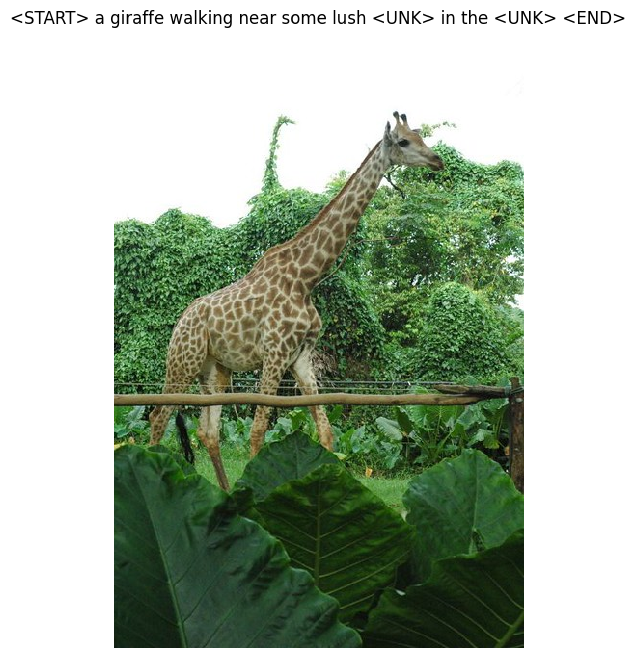

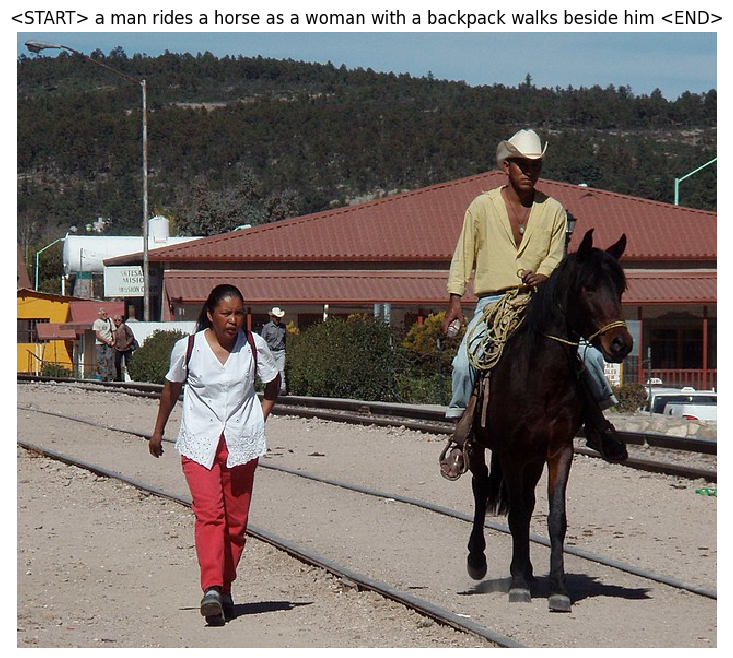

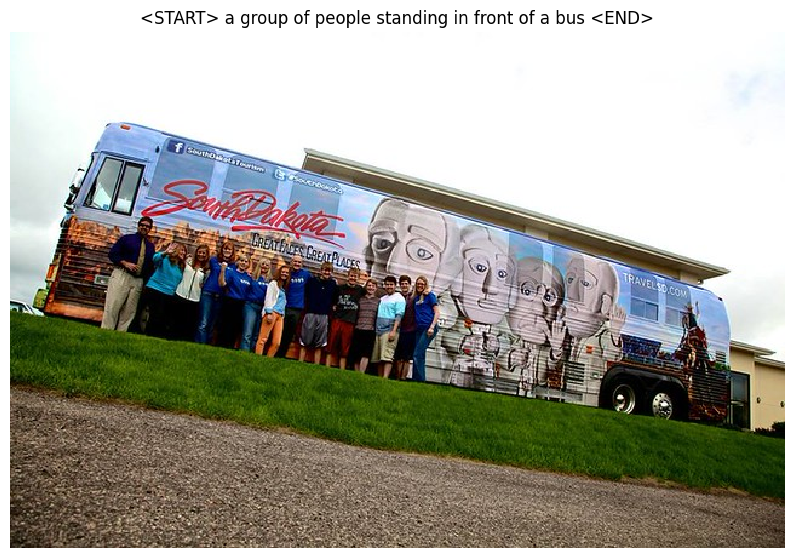

In [37]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

### Practice: design a RNN to caption these images

In [38]:
# design a RNN model that input features and output captions
print(captions.shape)
print(features.shape)

(3, 17)
(3, 512)


In [39]:
class CaptionRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size, num_layers=1 ):
        super(CaptionRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)

        # Define the RNN layer
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    # TODO: you need to modify this function to give correct output
    def forward(self, features, captions):
        outputs = []
        return outputs


In [ ]:
# Training 
